## Work
1. 請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [1]:
import os
import keras
import itertools

# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
def build_mlp(input_shape, output_units=10, num_neurons=[128, 256, 512]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
## 超參數設定
LEARNING_RATE = [1e-1, 1e-3]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = [0.9, 0.99]

In [7]:
results = {}
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for lr, momentum in itertools.product(LEARNING_RATE, MOMENTUM):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f, Momentum = %.2f" % (lr, momentum))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=momentum)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-lr-%s-momemtum-%s" % (str(lr), str(momentum))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}





Experiment with LR = 0.100000, Momentum = 0.90


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               33024     
_________________________________________________________________
hidden_layer3 (Dense)        (None, 512)               131584    
_________________________________________________________________
output (Dense)               (None, 10)                5130      
Total params: 563,082
Trainable params: 563,082
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the sam

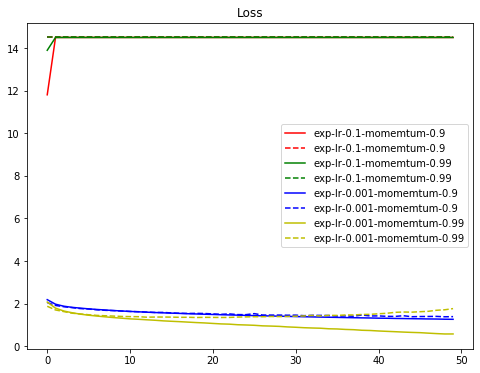

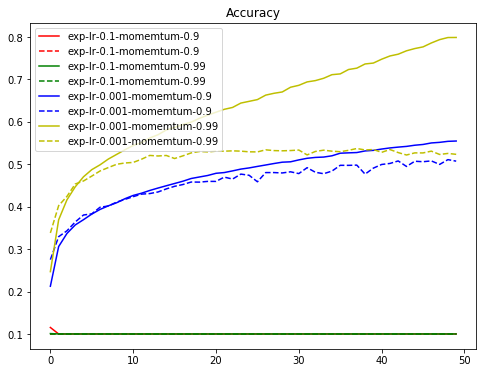

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()